## Similarity Metric Design

In [1]:
import numpy as np
import pandas as pd
import json
import pickle
import dataclasses
from dataclasses import dataclass, fields, _MISSING_TYPE
from heapq import heappush, heappop, heappushpop
from collections import OrderedDict
import math
import matplotlib.pyplot as plt
import spacy
from spacy import displacy
from entropy_calculation import uncertainty
from state_utils import get_spacy_info, get_llm_info, align_llm_spacy_output, get_model_state, StateOverview
from sentence_transformers import SentenceTransformer
from numpy.linalg import norm
from scipy.spatial.distance import cityblock, minkowski, jaccard
import yake
from copy import deepcopy
from similarity_utils import SimilarityScore

In [2]:
# spaCy trained pipelines for English

# 1. en_core_web_sm (12 MB): Vocabulary, syntax, entities
#     TAGGER (pos_): $, '', ,, -LRB-, -RRB-, ., :, ADD, AFX, CC, CD, DT, EX, FW, HYPH, IN, JJ, JJR, JJS, LS, MD, NFP, NN, NNP, NNPS, NNS, PDT, POS, PRP, PRP$, RB, RBR, RBS, RP, SYM, TO, UH, VB, VBD, VBG, VBN, VBP, VBZ, WDT, WP, WP$, WRB, XX, _SP, ``
#     Parse (dep_): ROOT, acl, acomp, advcl, advmod, agent, amod, appos, attr, aux, auxpass, case, cc, ccomp, compound, conj, csubj, csubjpass, dative, dep, det, dobj, expl, intj, mark, meta, neg, nmod, npadvmod, nsubj, nsubjpass, nummod, oprd, parataxis, pcomp, pobj, poss, preconj, predet, prep, prt, punct, quantmod, relcl, xcomp
#     NER: CARDINAL, DATE, EVENT, FAC, GPE, LANGUAGE, LAW, LOC, MONEY, NORP, ORDINAL, ORG, PERCENT, PERSON, PRODUCT, QUANTITY, TIME, WORK_OF_ART

# 2. en_core_web_md (40 MB): Vocabulary, syntax, entities, vectors
#     TAGGER (pos_): $, '', ,, -LRB-, -RRB-, ., :, ADD, AFX, CC, CD, DT, EX, FW, HYPH, IN, JJ, JJR, JJS, LS, MD, NFP, NN, NNP, NNPS, NNS, PDT, POS, PRP, PRP$, RB, RBR, RBS, RP, SYM, TO, UH, VB, VBD, VBG, VBN, VBP, VBZ, WDT, WP, WP$, WRB, XX, _SP, ``
#     Parse (dep_): ROOT, acl, acomp, advcl, advmod, agent, amod, appos, attr, aux, auxpass, case, cc, ccomp, compound, conj, csubj, csubjpass, dative, dep, det, dobj, expl, intj, mark, meta, neg, nmod, npadvmod, nsubj, nsubjpass, nummod, oprd, parataxis, pcomp, pobj, poss, preconj, predet, prep, prt, punct, quantmod, relcl, xcomp
#     NER: CARDINAL, DATE, EVENT, FAC, GPE, LANGUAGE, LAW, LOC, MONEY, NORP, ORDINAL, ORG, PERCENT, PERSON, PRODUCT, QUANTITY, TIME, WORK_OF_ART

# 3. en_core_web_lg (560 MB): Vocabulary, syntax, entities, vectors
#     TAGGER (pos_): $, '', ,, -LRB-, -RRB-, ., :, ADD, AFX, CC, CD, DT, EX, FW, HYPH, IN, JJ, JJR, JJS, LS, MD, NFP, NN, NNP, NNPS, NNS, PDT, POS, PRP, PRP$, RB, RBR, RBS, RP, SYM, TO, UH, VB, VBD, VBG, VBN, VBP, VBZ, WDT, WP, WP$, WRB, XX, _SP, ``
#     Parse (dep_): ROOT, acl, acomp, advcl, advmod, agent, amod, appos, attr, aux, auxpass, case, cc, ccomp, compound, conj, csubj, csubjpass, dative, dep, det, dobj, expl, intj, mark, meta, neg, nmod, npadvmod, nsubj, nsubjpass, nummod, oprd, parataxis, pcomp, pobj, poss, preconj, predet, prep, prt, punct, quantmod, relcl, xcomp
#     NER: CARDINAL, DATE, EVENT, FAC, GPE, LANGUAGE, LAW, LOC, MONEY, NORP, ORDINAL, ORG, PERCENT, PERSON, PRODUCT, QUANTITY, TIME, WORK_OF_ART

# 4. en_core_web_tf (438 MB): Vocabulary, syntax, entities
#     TAGGER (pos_): $, '', ,, -LRB-, -RRB-, ., :, ADD, AFX, CC, CD, DT, EX, FW, HYPH, IN, JJ, JJR, JJS, LS, MD, NFP, NN, NNP, NNPS, NNS, PDT, POS, PRP, PRP$, RB, RBR, RBS, RP, SYM, TO, UH, VB, VBD, VBG, VBN, VBP, VBZ, WDT, WP, WP$, WRB, XX, ``
#     Parse (dep_): ROOT, acl, acomp, advcl, advmod, agent, amod, appos, attr, aux, auxpass, case, cc, ccomp, compound, conj, csubj, csubjpass, dative, dep, det, dobj, expl, intj, mark, meta, neg, nmod, npadvmod, nsubj, nsubjpass, nummod, oprd, parataxis, pcomp, pobj, poss, preconj, predet, prep, prt, punct, quantmod, relcl, xcomp
#     NER: CARDINAL, DATE, EVENT, FAC, GPE, LANGUAGE, LAW, LOC, MONEY, NORP, ORDINAL, ORG, PERCENT, PERSON, PRODUCT, QUANTITY, TIME, WORK_OF_ART

**Similarity Measurement from Embeddings**

| Measure | Meaning | Relationship to increasing similarity |
| --- | --- | --- |
| Euclidean distance | Distance between ends of vectors | Decreases |
| Cosine | Cosine of angle $\theta$ between vectors | Increases |
| Dot Product | Cosine multiplied by lengths of both vectors | Increases. Also increases with length of vectors. |
| Manhattan distance | Sum of distances between the coordinates | Decrease |
| Minkowski distance | Feneralisation of the Euclidean and Manhattan distances | Decrease |
| Jaccard similarity | Intersection over Union | Decreases |

**Similarity Metric**

* Passage-level: Cosine, Euclidean, Dot, Manhattan, Minkowski, Jaccard <br><br>
* Sentence-level: Cosine, Euclidean, Dot, Manhattan, Minkowski, Jaccard <br><br>
* Token-level: Cosine, Euclidean, Dot, Manhattan, Minkowski, Jaccard <br><br>
* Keyword Coverage: Major Tag(NOUN, VERB), Minor TAg(others) <br><br>
* Alternative Token Alignment: State.token w.r.t other alternative tokens -> Cosine, Pos_tag cross-section <br><br>
* Final State Score: Weighted combination from above


In [3]:
# load sample response from datasets
load_path = "/Users/jiayangsong/Documents/git/LLM_analysis/hallucination_detection/response_data/"
dataset_name = "reponse_eli5_category_train_100.json"

df = pd.read_json(load_path+dataset_name)

print(f"dataset name: {dataset_name} \n" + 
      f"num of questions: {len(df)} \n" +
      f"dataset keys: {list(df.columns)} \n\n")

# take first reponse for later processing 
sample_response = df.iloc[3]

# extract response info 
num_token_response = sample_response["completion_tokens"]
top_k_prob = np.array(sample_response["top_k_prob"])
top_k_token = np.array(sample_response["top_k_token"])
top_logprobs = sample_response["top_logprobs"]
question = sample_response["question"]
text = sample_response["text"]
llm_token = sample_response["token"]

# display question, response from llm,  true answer
print(f"Question: {sample_response['question']} \n\n" + 
      f"Response: {repr(''.join((sample_response['text'])))} \n\n" + 
      f"Answer: {repr(''.join((sample_response['answer'])))} \n")

dataset name: reponse_eli5_category_train_100.json 
num of questions: 100 
dataset keys: ['question', 'answer', 'prompt', 'text', 'token', 'top_k_token', 'top_k_prob', 'top_logprobs', 'prompt_tokens', 'completion_tokens', 'response'] 


Question: Why is it that we calm down when we take a deep breath, hold it for a few seconds and exhale? 

Response: '\n\nTaking a deep breath helps to activate the parasympathetic nervous system, which is responsible for calming the body down. When we take a deep breath, we are sending a signal to the brain to relax and slow down. Holding the breath for a few seconds helps to increase the oxygen levels in the body, which can help to reduce stress and anxiety. Exhaling helps to release the tension in the body and can help to reduce stress levels.' 

Answer: 'Anxiety/stress are the result of your sympathetic nervous system being activated (fight or flight response). When we are threatened we experience a variety of physical effects, e.g. increased heart r

In [4]:
# state construction
nlp = spacy.load("en_core_web_lg")
doc = nlp(text)
nlp_result = get_spacy_info(doc)
llm_result = get_llm_info(text, llm_token, top_k_prob, top_k_token)
align_result = align_llm_spacy_output(nlp_result, llm_result, verbose=False)
states = get_model_state(align_result)
final_states = StateOverview(states, 4, ("NOUN", "VERB"), 0.3, "sentence", nlp)

# load embedding model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
weights= {"void":0}
# compute state score
scored_states = SimilarityScore(sample_response['text'], sample_response['answer'],
                                final_states, nlp, model, weights)


Note: 
> The keywrod score can be used as weights <br><br>
> For sentence level and token level similarity, normalization may be required. <br><br>
> If a state with NOUN/VERB tag is one of the keywords, give extra attention. <br><br>
> Semantics similarity: https://github.com/gsi-upm/sematch

### Score Visualization

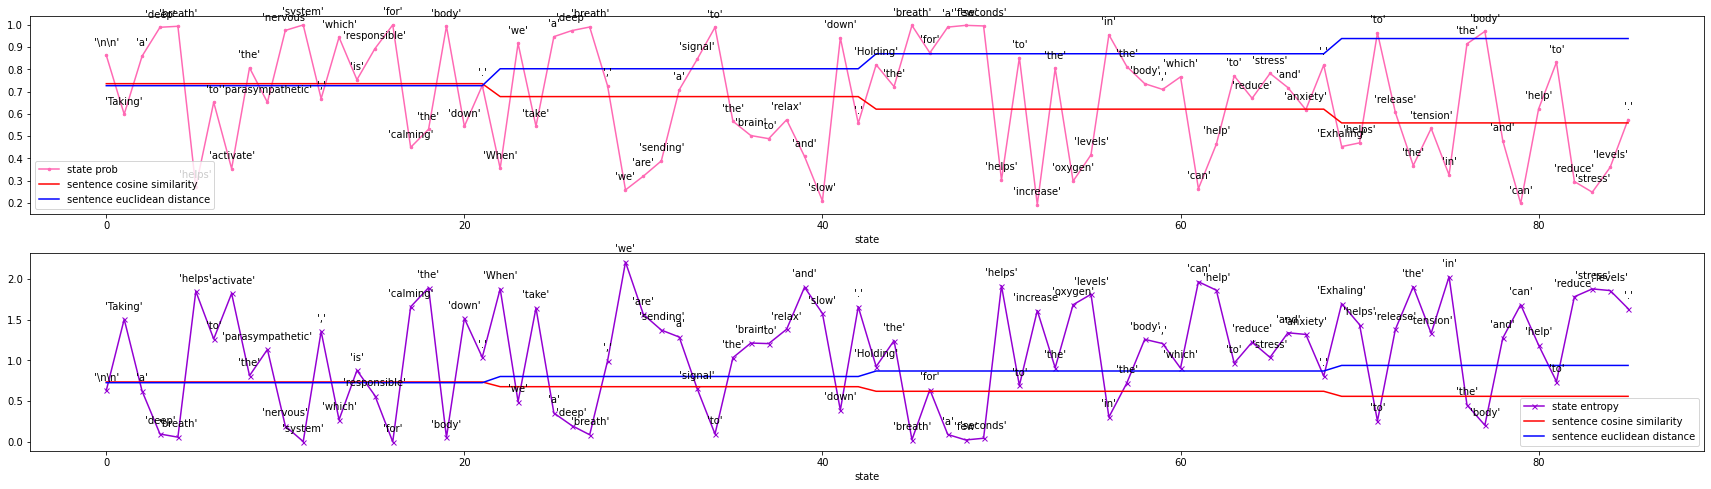

In [17]:
# sentence similarity
sentence_sim_list = scored_states.sentence_score
sentence_cosine = np.zeros(len(final_states.states))
sentence_euclidean = sentence_cosine.copy()

start_index = 0
for i, end_index in enumerate(scored_states.final_states.end_state_index):
    sentence_cosine[start_index:end_index] = scored_states.sentence_score[i]["cosine"]
    sentence_euclidean[start_index:end_index] = scored_states.sentence_score[i]["euclidean"]
    start_index = end_index

state_text = [state.token for state in final_states.states]
state_probability = [state.probability for state in final_states.states]
state_entropy = [state.entropy for state in final_states.states]
state_count = np.arange(len(state_text))
plot_colors = ['hotpink','darkviolet','mediumblue', 'purple', 'brown']

fig, axs = plt.subplots(2, 1, figsize=(30, 8))

axs[0].plot(state_count, state_probability, marker=".", markersize=5, c=plot_colors[0], label="state prob")
axs[0].plot(state_count, sentence_cosine, c="r", label="sentence cosine similarity")
axs[0].plot(state_count, sentence_euclidean, c="b", label="sentence euclidean distance")
# axs[0].set_ylabel('Probability')
axs[0].set_xlabel(f'state')
axs[0].legend()
# axs[0].set_ylim([0, 1])


axs[1].plot(state_count, state_entropy, marker="x", markersize=5, c=plot_colors[1], label="state entropy")
axs[1].plot(state_count, sentence_cosine, c="r", label="sentence cosine similarity")
axs[1].plot(state_count, sentence_euclidean, c="b", label="sentence euclidean distance")
# axs[1].set_ylabel('Shannon Entropy')
axs[1].set_xlabel("state")
axs[1].legend()
# axs[1].set_ylim([0, 2.2])

# zip joins x and y coordinates in pairs
for index, value in enumerate([state_probability, state_entropy]):
    # zip joins x and y coordinates in pairs
    for x,y in zip(state_count, value):

        label = repr(state_text[x])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center
plt.show()

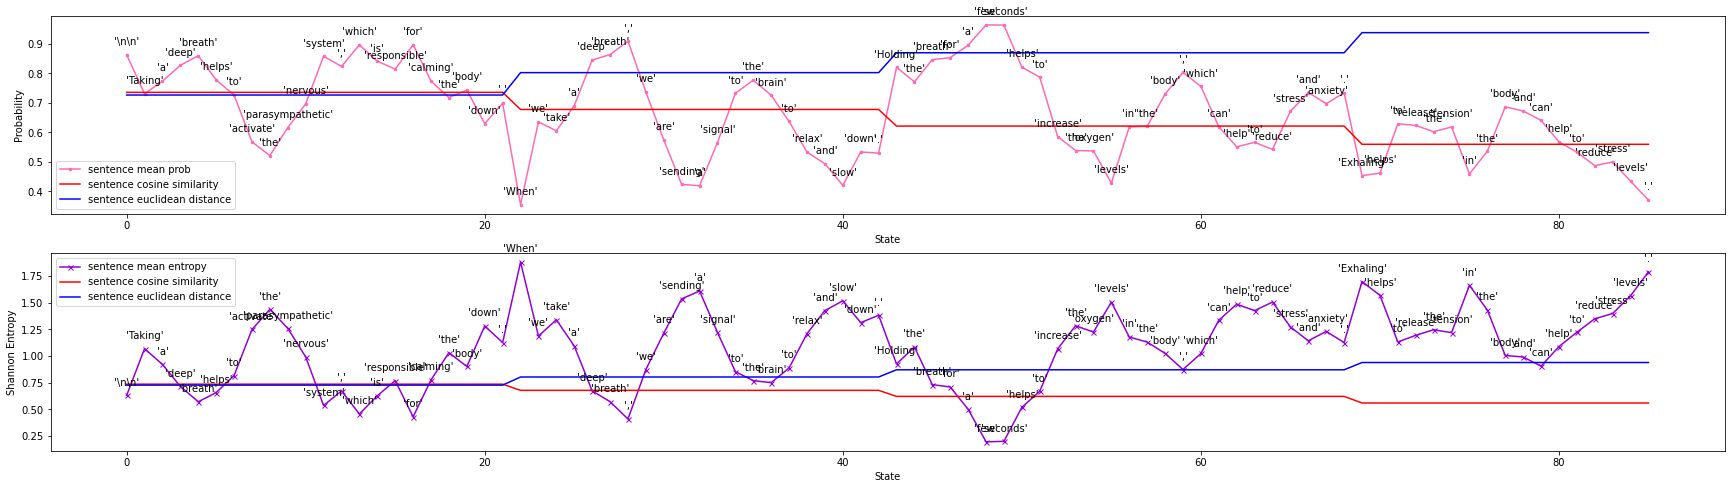

In [18]:
sentence_mean_prob = [state.statistics.moving_mean["sentence_prob"] for state in final_states.states]
sentence_mean_entropy = [state.statistics.moving_mean["sentence_entropy"] for state in final_states.states]

fig, axs = plt.subplots(2, 1, figsize=(30, 8))

axs[0].plot(state_count, sentence_mean_prob, marker=".", markersize=5, c=plot_colors[0], label="sentence mean prob")
axs[0].plot(state_count, sentence_cosine, c="r", label="sentence cosine similarity")
axs[0].plot(state_count, sentence_euclidean, c="b", label="sentence euclidean distance")
axs[0].set_ylabel('Probability')
axs[0].set_xlabel(f'State')
axs[0].legend()
# axs[0].set_ylim([0, 1])

axs[1].plot(state_count, sentence_mean_entropy, marker="x", markersize=5, c=plot_colors[1], label="sentence mean entropy")
axs[1].plot(state_count, sentence_cosine, c="r", label="sentence cosine similarity")
axs[1].plot(state_count, sentence_euclidean, c="b", label="sentence euclidean distance")
axs[1].set_ylabel('Shannon Entropy')
axs[1].set_xlabel("State")
axs[1].legend()
# axs[1].set_ylim([0, 2.2])

# zip joins x and y coordinates in pairs
for index, value in enumerate([sentence_mean_prob, sentence_mean_entropy]):
    # zip joins x and y coordinates in pairs
    for x,y in zip(state_count, value):

        label = repr(state_text[x])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center
plt.show()

### State Metric

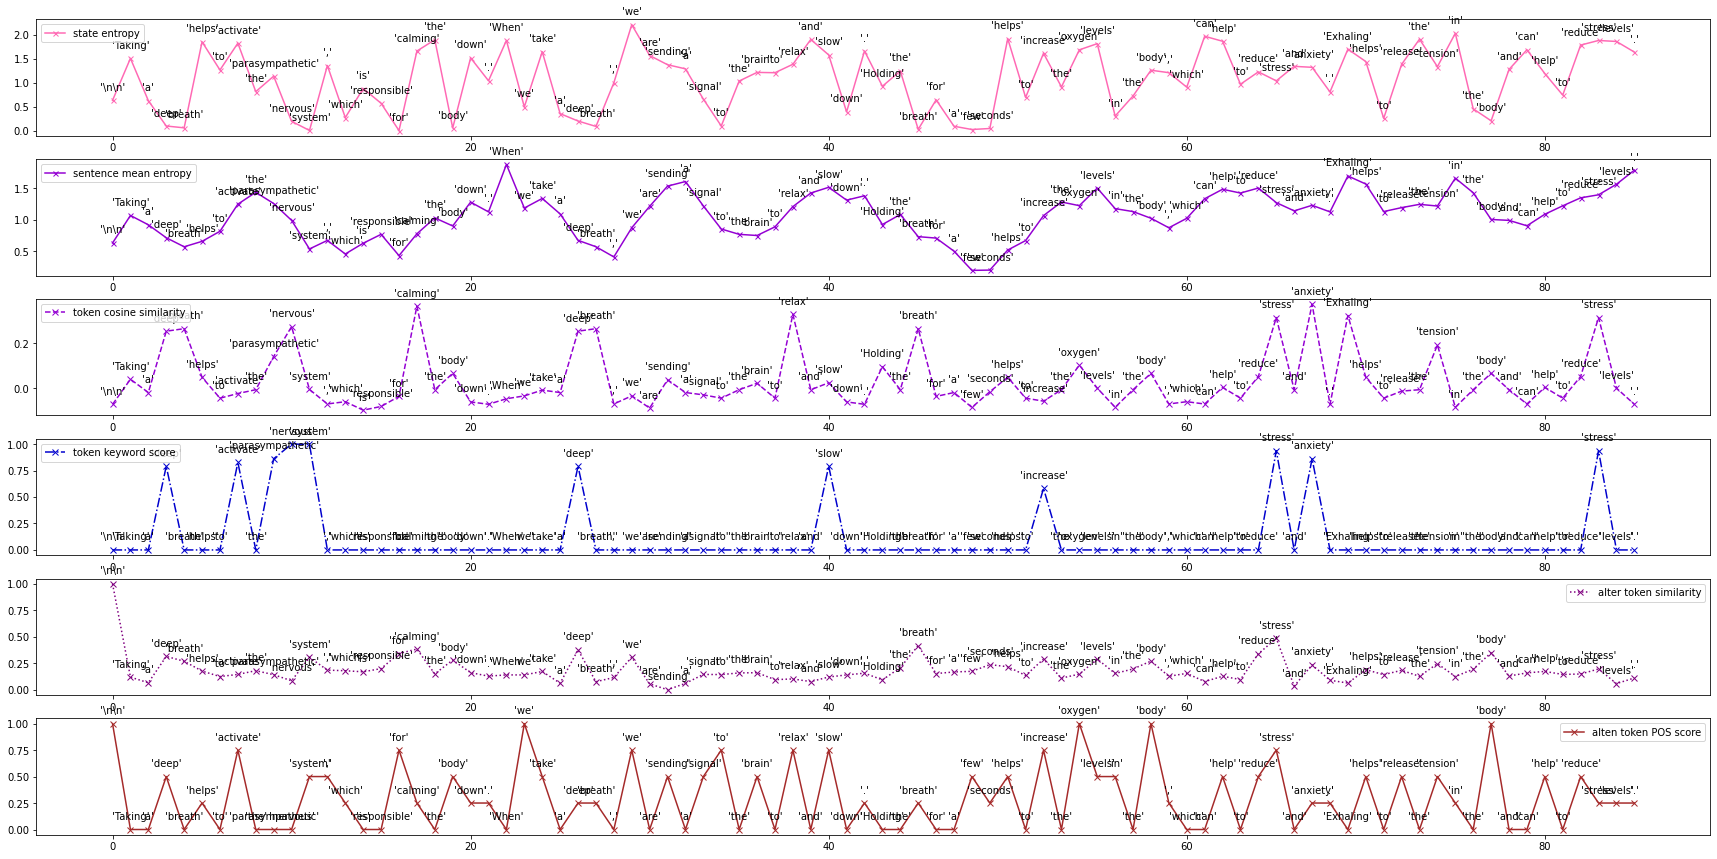

In [19]:
token_cosine = [toekn_score["cosine"] for toekn_score in scored_states.token_score]
keyword_score = scored_states.keyword_score
alter_token_sim_score = scored_states.alter_token_sim_score
alter_token_pos_score = scored_states.alter_token_pos_score

sentence_mean_prob = [state.statistics.moving_mean["sentence_prob"] for state in final_states.states]
sentence_mean_entropy = [state.statistics.moving_mean["sentence_entropy"] for state in final_states.states]

fig, axs = plt.subplots(6, 1, figsize=(30, 15))

axs[0].plot(state_count, state_entropy, marker="x", markersize=5, c=plot_colors[0], label="state entropy")
axs[1].plot(state_count, sentence_mean_entropy, marker="x", markersize=5, c=plot_colors[1], label="sentence mean entropy")
axs[2].plot(state_count, token_cosine,'--', marker="x", c=plot_colors[1], label="token cosine similarity")
axs[3].plot(state_count, keyword_score, '-.', marker="x", c=plot_colors[2], label="token keyword score")
axs[4].plot(state_count, alter_token_sim_score, ':', marker="x", c=plot_colors[3], label="alter token similarity")
axs[5].plot(state_count, alter_token_pos_score, marker="x", c=plot_colors[4], label="alten token POS score")

# zip joins x and y coordinates in pairs
for index, value in enumerate([state_entropy, sentence_mean_entropy, token_cosine, keyword_score, alter_token_sim_score, alter_token_pos_score]):
    # zip joins x and y coordinates in pairs
    for x,y in zip(state_count, value):

        label = repr(state_text[x])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center
        axs[index].legend()
plt.show()

### Selected Weighted states moving mean entropy

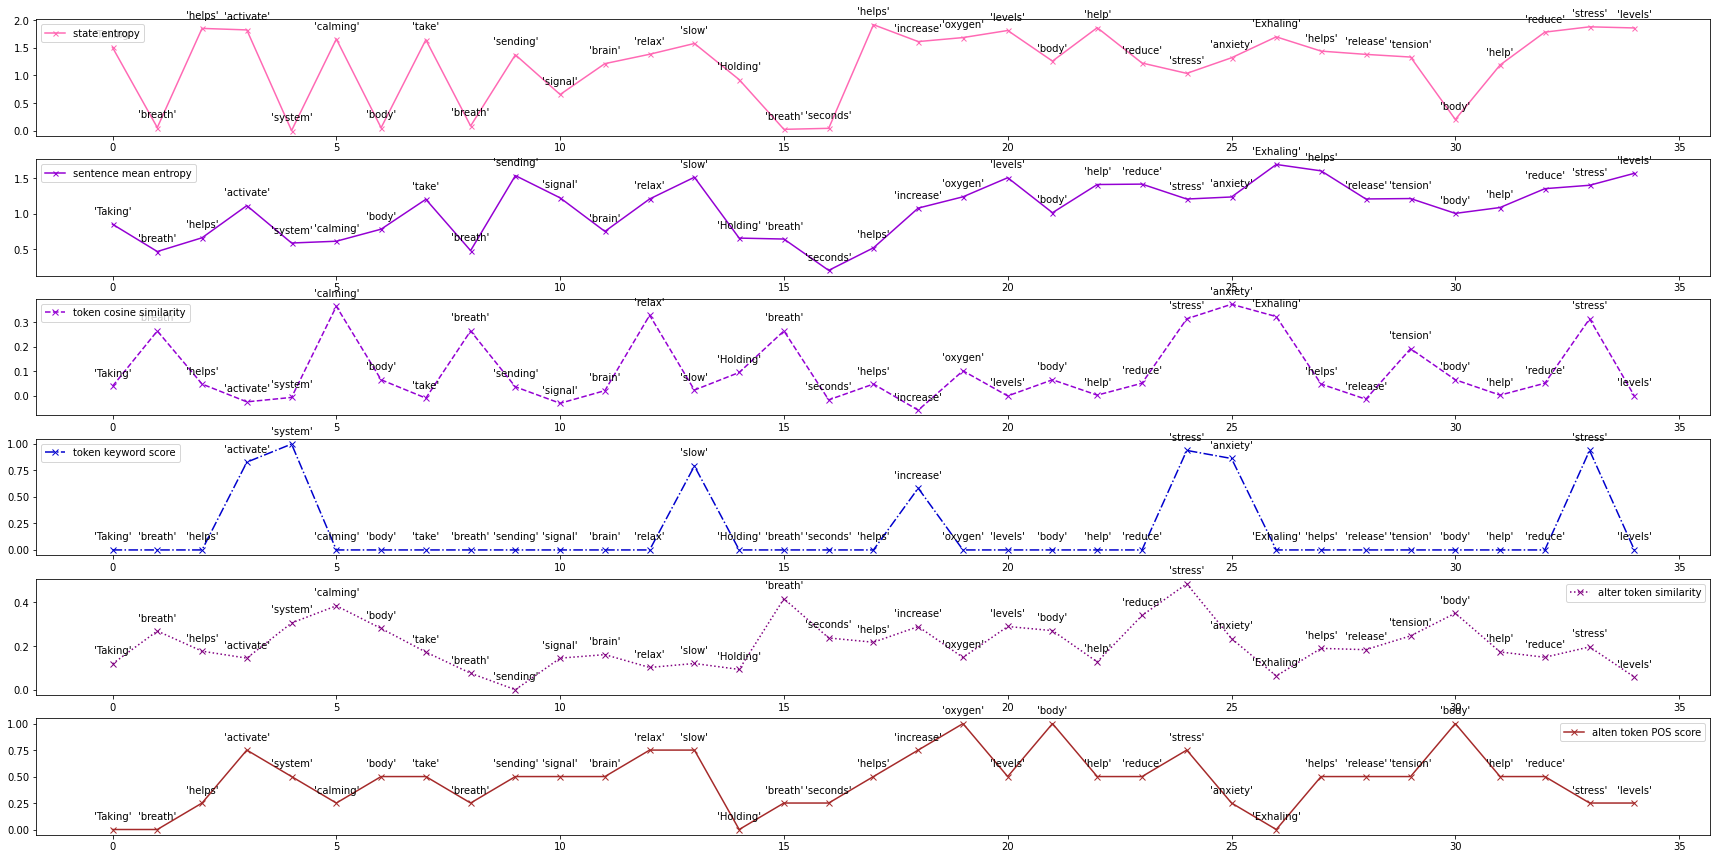

In [20]:
target_tag = set(["NOUN", "VERB"])
select_state = []

for state in final_states.states:
    if state.prop_tag.pos_tag in target_tag:
        select_state.append(state)

select_state_index = [int(state.idx) for state in select_state]
select_state_text = [state.token for state in select_state]
select_state_probability = [state.probability for state in select_state]
select_state_entropy = [state.entropy for state in select_state]
select_state_count = np.arange(len(select_state_text))

select_state_entropy = [state_entropy[i] for i in select_state_index]
select_weight_sentence_mean_prob = [state.statistics.weighted_moving_mean["sentence_prob"] for state in select_state]
select_weight_sentence_mean_entropy = [state.statistics.weighted_moving_mean["sentence_entropy"] for state in select_state]
select_token_cosine =[token_cosine[i] for i in select_state_index]
select_keyword_score = [keyword_score[i] for i in select_state_index]
select_alter_token_sim_score = [alter_token_sim_score[i] for i in select_state_index]
select_alter_token_pos_score = [alter_token_pos_score[i] for i in select_state_index]


fig, axs = plt.subplots(6, 1, figsize=(30, 15))

axs[0].plot(select_state_count, select_state_entropy, marker="x", markersize=5, c=plot_colors[0], label="state entropy")
axs[1].plot(select_state_count, select_weight_sentence_mean_entropy, marker="x", markersize=5, c=plot_colors[1], label="sentence mean entropy")
axs[2].plot(select_state_count, select_token_cosine,'--', marker="x", c=plot_colors[1], label="token cosine similarity")
axs[3].plot(select_state_count, select_keyword_score, '-.', marker="x", c=plot_colors[2], label="token keyword score")
axs[4].plot(select_state_count, select_alter_token_sim_score, ':', marker="x", c=plot_colors[3], label="alter token similarity")
axs[5].plot(select_state_count, select_alter_token_pos_score, marker="x", c=plot_colors[4], label="alten token POS score")

# zip joins x and y coordinates in pairs
for index, value in enumerate([select_state_entropy, select_weight_sentence_mean_entropy, select_token_cosine, 
                               select_keyword_score, select_alter_token_sim_score, select_alter_token_pos_score]):
    # zip joins x and y coordinates in pairs
    for x,y in zip(select_state_count, value):

        label = repr(select_state_text[x])
        axs[index].annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center')   # horizontal alignment can be left, right or center
        axs[index].legend()
plt.show()


### Collect states info from datasets

In [86]:
nlp = spacy.load("en_core_web_lg")
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
weights= {"void":0}
collect_states = list()

for i in range(len(df)):
    if i%10 == 0: print(i)
    try:
        response = df.iloc[i]
        nlp_result = get_spacy_info(nlp(response["text"]))
        llm_result = get_llm_info(response["text"], response["token"], np.array(response["top_k_prob"]), np.array(response["top_k_token"]))
        align_result = align_llm_spacy_output(nlp_result, llm_result, verbose=False)
        states = get_model_state(align_result)
        final_states = StateOverview(states, 4, ("NOUN", "VERB"), 0.3, "sentence", nlp)
        scored_states = SimilarityScore(response['text'], response['answer'], final_states, nlp, model, weights)
        collect_states.append(scored_states)
    except:
        collect_states.append([])
        print(f"Error encountered at: {i}")
        

0
10
word-token mismatch:  ♡ is a stylize - bytes: \xe2\x99
Error encountered at: 13
20


/Users/jiayangsong/Documents/git/LLM_analysis/hallucination_detection/state_utils.py:117: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  alter_token_score.append(self.nlp_model(state.token).similarity(self.nlp_model(token)))


30
40
50
60
word-token mismatch:  “the light goi - bytes: \xe2\x80
Error encountered at: 60
70
Error encountered at: 75
80
90


In [100]:
# for result in collect_states:
#     if type(result) != list:
#         delattr(result, 'final_states')
        
states_to_save = deepcopy(collect_states)
# index_to_delete = []
# for i, result in enumerate(states_to_save):
#     if type(result) == list:
#         del states_to_save[result]
#         index_to_delete.append(i)

df_to_save = df.copy(deep=True)
# df_to_save = df_to_save.drop(index_to_delete)
df_to_save["scored_states"] = collect_states

### save data

In [103]:
# save scored staets df
# df_to_save = df.copy()
name_to_save = "response_eli5_category_train_100_scored"
save_path = "/Users/jiayangsong/Documents/git/LLM_analysis/hallucination_detection/scored_data/"

# df_to_save.to_json(save_path + name_to_save + ".json", orient="columns")
df_to_save.to_pickle(save_path + name_to_save + ".pkl")

In [105]:
load_path = "/Users/jiayangsong/Documents/git/LLM_analysis/hallucination_detection/scored_data/"
dataset_name = "response_eli5_category_train_100_scored.pkl"

new_df = pd.read_pickle(load_path+dataset_name)

question             Why is it that we calm down when we take a dee...
answer               Anxiety/stress are the result of your sympathe...
prompt               Answer the following question with reasons wit...
text                 \n\nTaking a deep breath helps to activate the...
token                [\n, \n, Taking,  a,  deep,  breath,  helps,  ...
top_k_token          [[\n,  , \n\n,   ,    ], [\n,  ,   , Answer,  ...
top_k_prob           [[0.8635202246, 0.1267306894, 0.0083863105, 0....
top_logprobs         [{'
': -0.14673796, '

': -4.7811546, ' ': -2....
prompt_tokens                                                       38
completion_tokens                                                   92
response             {'id': 'cmpl-77g7DuBWYc948fQ40Mn5Lcd82NZeb', '...
scored_states        <similarity_utils.SimilarityScore object at 0x...
Name: 3, dtype: object

In [110]:
new_df.iloc[3].scored_states.keywords

{'nervous': 1.0,
 'system': 0.9970615555566601,
 'stress': 0.9369847319122704,
 'breathing': 0.9287605353782286,
 'response': 0.905677366040482,
 'rate': 0.8933783435889955,
 'anxiety': 0.8609499387788204,
 'parasympathetic': 0.8609499387788204,
 'sympathetic': 0.8266287626421365,
 'activate': 0.8266287626421365,
 'threaten': 0.8266287626421365,
 'heart': 0.8266287626421365,
 'fight': 0.7905516629681886,
 'muscle': 0.7905516629681886,
 'slow': 0.7905516629681886,
 'deep': 0.7905516629681886,
 'effect': 0.5814093797066886,
 'increase': 0.5814093797066886,
 'upset': 0.5814093797066886,
 'jittery': 0.5814093797066886,
 'rapid': 0.5814093797066886,
 'helpful': 0.5814093797066886,
 'sabre': 0.5814093797066886,
 'toothe': 0.5814093797066886,
 'tiger': 0.5814093797066886,
 'group': 0.5814093797066886,
 'set': 0.5814093797066886,
 'bod': 0.5814093797066886,
 'relaxation': 0.5814093797066886,
 'provoke': 0.5814093797066886,
 'event': 0.5814093797066886,
 'basically': 0.5814093797066886,
 'unthr